# First preliminary analysis of the proteomic data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import fastcluster
from sklearn.preprocessing import StandardScaler
import polars as pl


In [124]:
## download the raw and the normalized signal data 

raw_data = pd.read_csv("./inputs/proteomics_data/raw_concentration.csv", sep=',')
## file of proteomic data with the normalized signal
norm_signal_prot = pd.read_csv("./inputs/proteomics_data/normalized_signal.csv", sep=',') 

In [6]:
## our filtered file without the fully missing proteins
norm_signal= pd.read_csv("./outputs/norm_signal_filtered.csv", sep=',')

norm_signal['Metadata_Plate']

0      BR00145683
1      BR00145683
2      BR00145683
3      BR00145683
4      BR00145683
          ...    
763    BR00145686
764    BR00145686
765    BR00145686
766    BR00145686
767    BR00145686
Name: Metadata_Plate, Length: 768, dtype: object

In [3]:
norm_signal

,O14672,P78536,Q13443,Q9UHI8,Q9UNA0,Q15848,Q15389,Q9Y5C1,Q9BY76,O43827,...,O43915,P35968,Q9Y5W5,O95388,P41221,P47992,Metadata_Plate,Metadata_Well,Metadata_Compound,Metadata_Concentration
0,0.02,0.00,0.00,0.00,0.01,0.02,0.12,0.04,0.45,0.00,...,-0.01,0.00,-0.01,-0.02,0.00,0.01,BR00145683,A01,UNTREATED,0.000
1,0.02,0.06,0.05,0.06,0.04,0.01,0.07,0.10,0.10,0.03,...,-0.01,-0.04,0.04,-0.02,0.00,0.00,BR00145683,A02,Actinomycin D,300.000
2,0.01,0.01,0.00,0.01,0.01,0.01,0.16,0.04,0.51,0.00,...,0.00,-0.01,0.00,0.00,0.00,-0.05,BR00145683,A03,Bevirimat,3.704
3,0.00,-0.01,0.00,0.01,0.02,0.01,0.16,0.01,0.47,-0.04,...,-0.01,0.00,0.00,-0.01,0.00,-0.04,BR00145683,A04,Ethoxyquin,0.137
4,0.01,-0.01,0.00,-0.01,0.00,0.02,0.15,0.00,0.48,-0.01,...,0.01,0.00,0.02,-0.01,0.00,0.00,BR00145683,A05,UNTREATED,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.00,0.00,0.00,0.01,0.00,0.01,0.16,0.00,0.48,0.02,...,0.01,-0.01,0.00,0.00,0.01,-0.01,BR00145686,P20,Natamycin,2.500
764,-0.01,0.01,-0.01,0.00,0.00,0.02,0.17,0.00,0.48,0.02,...,-0.01,-0.01,0.00,-0.01,0.01,0.00,BR00145686,P21,MILTEFOSINE,7.500
765,0.01,0.01,0.00,-0.01,0.00,0.02,0.15,0.01,0.51,0.00,...,0.00,-0.01,-0.01,0.00,0.00,0.01,BR00145686,P22,IOPANOIC ACID,100.000
766,0.02,0.01,-0.01,0.00,-0.02,0.02,0.15,0.00,0.47,0.00,...,-0.03,0.00,0.01,0.03,-0.01,0.01,BR00145686,P23,Aminodarone Hydrochloride,0.017


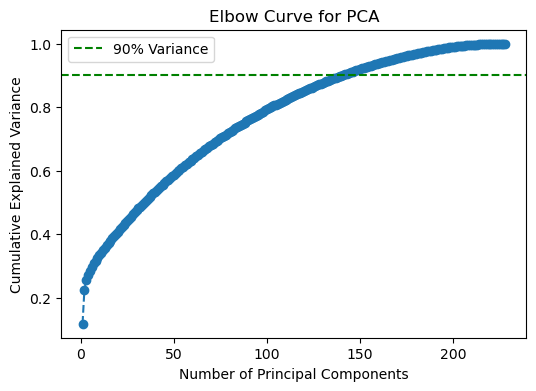

Number of components to explain 99% of variance: 141


In [135]:
# PCA analysis to determine the number of components to explain 99% of variance

norm_signal_filtered = norm_signal.drop(columns=[col for col in norm_signal.columns if col.startswith("Metadata")])

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA()
pca.fit(scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_99 = np.argmax(cumulative_variance >= 0.90) + 1



plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='g', linestyle='--', label="90% Variance")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Curve for PCA')
plt.legend()
plt.show()

print(f"Number of components to explain 99% of variance: {n_components_99}")

In [4]:
## non scaled data PCA

n_components_99= 6
pca = PCA(n_components_99)
principal_components = pca.fit_transform(norm_signal_filtered)

column_names = [f'PC{i+1}' for i in range(n_components_99)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names)
pca_df.index = norm_signal_filtered.index 

pca_df['Plate'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_Plate']
pca_df['Compound'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_Compound']
pca_df['Concentration'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_Concentration']
pca_df= pca_df.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 0.2), loc='upper left')
plt.show()

NameError: name 'norm_signal_filtered' is not defined

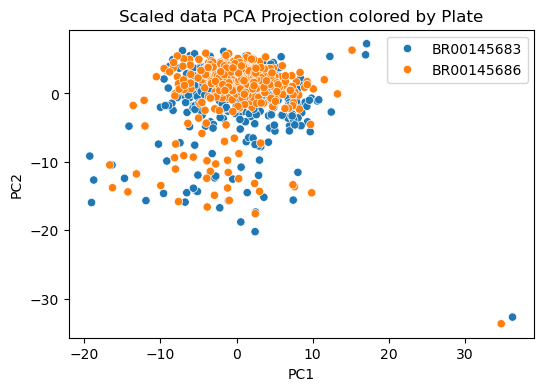

In [138]:
## scaled data PCA

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA()
pca.fit(scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1


pca = PCA(n_components=n_components_99)
principal_components = pca.fit_transform(scaled)


column_names = [f'PC{i+1}' for i in range(n_components_99)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names, index=norm_signal_filtered.index)


pca_df['Plate'] = norm_signal.loc[pca_df.index, 'Metadata_Plate']
pca_df['Compound'] = norm_signal.loc[pca_df.index, 'Metadata_Compound']
pca_df['Concentration'] = norm_signal.loc[pca_df.index, 'Metadata_Concentration']

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scaled data PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

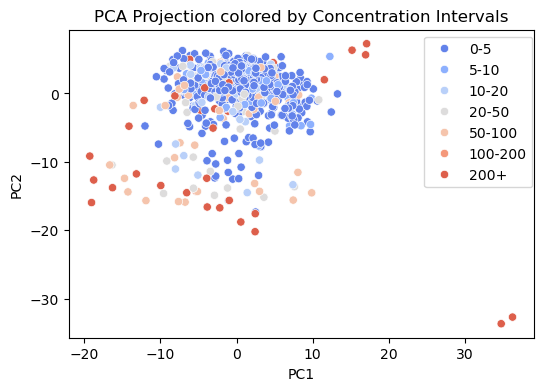

In [139]:
##scaled data PCA colored by concentration intervals

bins = [0, 5, 10, 20, 50, 100, 200, 300] 
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200+']  


pca_df['Concentration_Binned'] = pd.cut(pca_df['Concentration'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Concentration_Binned'], palette="coolwarm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Concentration Intervals")
plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left')
plt.show()

['Untreated' 'Compound' 'DMSO']


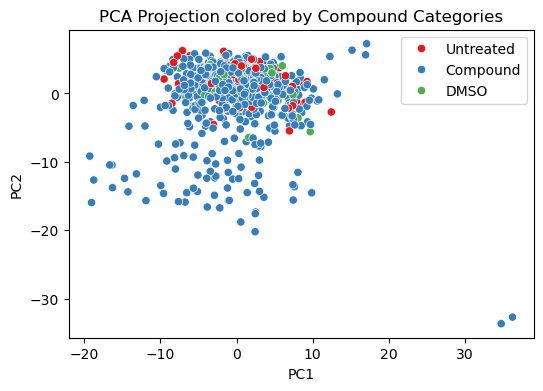

In [140]:
# scaled data PCA by compound categories

pca_df['Category'] = pca_df['Compound'].apply(
    lambda x: 'DMSO' if x == 'DMSO' else ('Untreated' if x == 'UNTREATED' else 'Compound')
)


print(pca_df['Category'].unique())

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Category'], palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Compound Categories")
plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left')
plt.show()



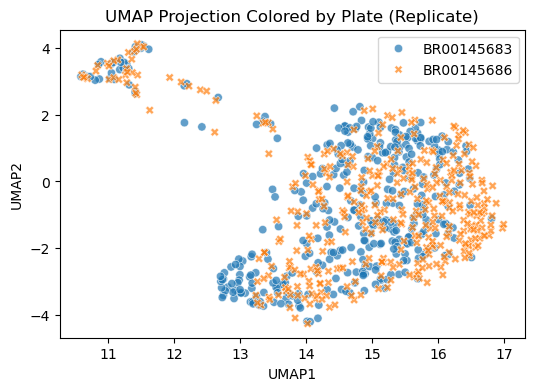

In [142]:
# UMAP projection of the scaled data

umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(scaled)

norm_signal["UMAP1"], norm_signal["UMAP2"] = umap_result[:, 0], umap_result[:, 1]


metadata_color =  "Metadata_Plate"  #"Metadata_compound_concentration"  


plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="UMAP1", y="UMAP2", hue=norm_signal[metadata_color], style=norm_signal["Metadata_Plate"],
    palette="tab10", data=norm_signal, alpha=0.7 )
plt.title("UMAP Projection Colored by Plate (Replicate)")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

### Scatterplots of replicates

In [143]:
## the list of compound with unique concentration values + DMSO/Untreated with 0uM concentration

single_concentration_compounds = norm_signal.groupby('Metadata_Compound')['Metadata_Concentration'].nunique()
compounds_with_single_concentration = single_concentration_compounds[single_concentration_compounds == 1].index
filtered_data = norm_signal[norm_signal['Metadata_Compound'].isin(compounds_with_single_concentration)]

print(compounds_with_single_concentration)

Index(['AMG 900', 'Aloxistatin', 'DMSO', 'Dexamethasone (DHAP)', 'FK-866',
       'LY2109761', 'NVS-PAK1-1', 'Quinidine', 'TC-S 7004', 'UNTREATED'],
      dtype='object', name='Metadata_Compound')


In [ ]:
## first 5 principal components tables, score per plate/replicate

num_pcs = 5  
pc_columns= [f"PC{i+1}" for i in range(num_pcs)]  


pca_pl = pl.DataFrame(pca_df)
pca_pl = pca_pl.filter(~pl.col("Compound").is_in(list(compounds_with_single_concentration)))

pca_melt = pca_pl.melt(
    id_vars=["Compound", "Concentration", "Plate"],
    value_vars=pc_columns,
    variable_name="PC",
    value_name="Score"
)

pc_tables = {}

for pc in pc_columns:
    globals()[pc.lower()] = pca_melt.filter(pl.col("PC") == pc).pivot(
        on="Plate",
        index=["Compound", "Concentration"],
        values="Score"
    ).to_pandas()

print(pc1.head())

        Compound  Concentration  BR00145683  BR00145686
0  Actinomycin D        300.000   36.297232   34.808771
1      Bevirimat          3.704    7.272313   -1.877016
2     Ethoxyquin          0.137    6.751128    4.632532
3     Amperozide          0.046    5.760509    3.276023
4  IOPANOIC ACID          3.704    7.993160   -2.659340


/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_4093/2970861907.py:10: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  pca_melt = pca_pl.melt(


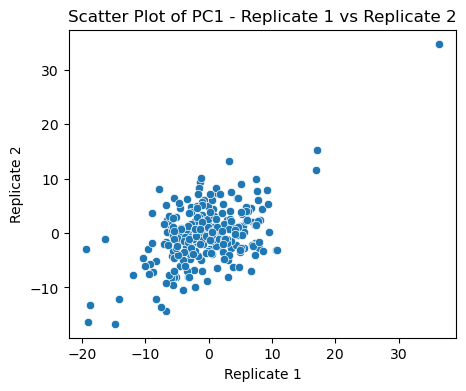

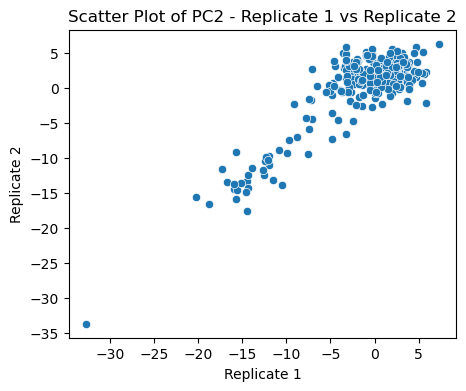

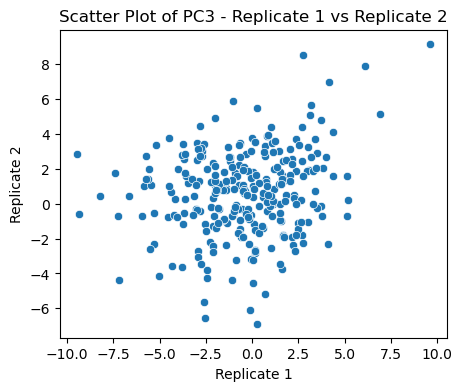

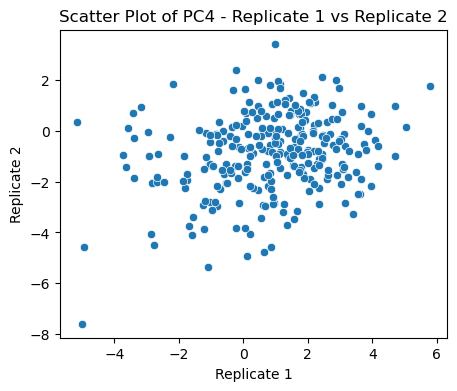

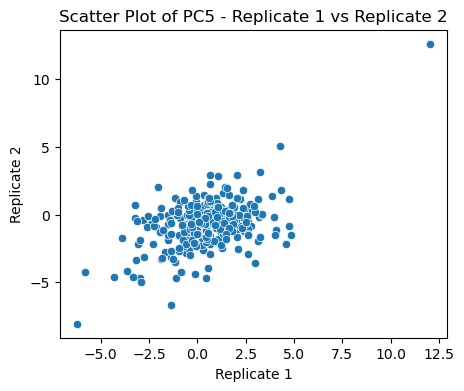

In [148]:
def plot_scatter_plots(pc_df, pc_name):

    for plate1, plate2 in [('BR00145683', 'BR00145686')]: 
        if plate1 in pc_df.columns and plate2 in pc_df.columns:
            plt.figure(figsize=(5, 4))
            sns.scatterplot(x=pc_df[plate1], y=pc_df[plate2]) #, hue=pc_df['Concentration'], palette="tab10")
            plt.title(f"Scatter Plot of {pc_name} - Replicate 1 vs Replicate 2")
            plt.xlabel("Replicate 1")
            plt.ylabel("Replicate 2")
            #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

pc_dataframes = [pc1, pc2, pc3, pc4, pc5]

for i, pc_df in enumerate(pc_dataframes, start=1):
    plot_scatter_plots(pc_df, f"PC{i}")


PC4 showed interesting patterns, both the high and low exposures are Cucurbitacin I. We should remember to look more closely later.